<h1>Two-Body Problem</h1>

<h3>A simulation that uses matplotlib to animate the motions of the heavenly bodies.</h3>
<p>Results stored in simulation.gif.</p>

In [10]:
# imports
from matplotlib.animation import PillowWriter
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from src.presets import preset

<h2>Constants and Formulas</h2>
<h3>Scale Factors</h3>

$$\Delta x = 1 \text { AU} = 149,597,870,700m $$

$$\Delta t = n \text{ days} = n\times86400s $$

### Formulas
$$ F_G = \frac{G\cdot m_1 \cdot m_2}{||\vec{r}||^2} \cdot \frac {\vec{r}}{||\vec{r}||} $$

$$ GPE = \frac{G\cdot m_1 \cdot m_2}{||\vec{r}||} $$

$$ KE = \frac{1}{2} m||\vec{v}||^2 $$

The barycenter is the center of mass of the system. It moves with velocity equal to the net linear momentum of the sytem.
The barycenter's position is given by:

$$ \vec{s}_{bary} = {\sum_{i=1}^N \frac{\vec{s}_i}{m_i}} $$

### Loading Presets

In [11]:
preset = preset("moon-pov")

In [12]:
# —unit scale factors—
L_SCALE = 149597870700 # m/unit length || 1 AU
T_SCALE = 86400*preset['t_scale'] # s/unit time || n Days w. n determined by preset

# —GIF properties—
GIF_PATH = f"results/{preset['name']}.gif"
FPS = 24 # timesteps per second of the GIF
RES = 100 # resolution of each frame, in DPI
T = range(int(preset['t']/preset['t_scale'])) # [T]  time the simulation runs for

# —field of view (FOV) properties—
cart = preset['mode'] == 'cartesian'

if cart:
	DIMS = list(preset['dims'].keys())
	DLIMS = []
	if 'x' in preset['dims']:
		XLIM = [1.25, 0.0025][preset['dims']['x']] # [L]  limits of the x-axis
		DLIMS.append(XLIM)
	if 'y' in preset['dims']:
		YLIM = [1.25, 0.0025][preset['dims']['y']] # [L]  limits of the y-axis
		DLIMS.append(YLIM)
	if 'z' in preset['dims']:
		ZLIM = [0.002, 0.001][preset['dims']['z']] # [L]  limits of the z-axis
		DLIMS.append(ZLIM)
else:
	XLIM = YLIM = 1
	DLIMS = [XLIM, YLIM]

ND = preset['ndims']
is3D = ND == 3 

# the index of the body that should be at the center of the FOV:
CENT = preset['center'] # 0-earth, 1-sun, 2-moon, 3-barycenter

# Newton's gravitational constant
G = 6.6743e-11 * T_SCALE**2 / L_SCALE**3 # [M]¯¹[L]³[T]¯²

# gravitational force
Fg = lambda m1, m2, r: G*m1*m2 * r/norm(r)**3 # [M][L][T]¯²

# energy functions  [M][L]²[T]¯²
GPE = lambda m1, m2, r: -G*m1*m2 / norm(r) # gravitational potential energy
KE = lambda m, v: m*norm(v)**2 / 2 # kinetic energy


def calc_barycenter(particle_list: list):
	"""Calculates the barycenter (center of mass) of the system of particles.
	-----------
	Parameters:
		particle_list: a list of the form [p1, p2, ..., pn] where pi is a tuple of form (mi, si)
	"""
	Σs = np.zeros(3)
	Σm = 0
	for p in particle_list:
		# sums up the products of mass and position, and the masses
		Σs += p[0]*p[1]
		Σm += p[0]
	return Σs/Σm

# def update(dt = 1):


## Initial Conditions

<h3>Orbits</h3>
<p>When looking from outside the Solar system at the Southern hemisphere, the Earth rotates and orbits the sun in a clockwise direction, and the moon rotates and orbits the Earth in a clockwise direction too.</br>
As a result, the times it takes for the sun to return to the same position in the sky and for the moon to return to the same phase are slightly longer than the time it takes for the Earth and moon to rotate/orbit 360 degrees, respectively. The Earth takes 23:56 to rotate 360 degrees but the time between two noons is 24:00 because it has also progressed in its orbit. Similarly, the moon completes a full revolution of the Earth in 27.3 days but the time between two full moons is 29.5 days, because the moon phase is defined relative to the sun, and the Earth has moved relative to the sun.

The moon orbits on a plane inclined by 5.14° relative to the ecliptic (the Earth-sun plane).</p>

<a href="https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html">Moon info</a> <br>
<a href="https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html">Earth info</a>

In [13]:
# —initial conditions —
ms = 1.9891E30 # [M]  mass of sun
me = 5.9722E24 # [M]  mass of earth
mm = 7.3477E22 # [M]  mass of moon

s0e = np.array([-1.0167, 0.0, 0.0]) # [L]  initial position of earth (aphelion)
s0s = np.array([0.0, 0.0, 0.0]) # [L]  initial position of sun
s0m = np.array([-1.0143, 0.0, -0.0002176]) # [L]  initial position of moon (perigee)

s0b = calc_barycenter([(me, s0e), (ms, s0s), (mm, s0m)]) # [L]  initial center of mass of the system

ue = np.array([0, 29290 * T_SCALE / L_SCALE, 0]) # [L][T]¯1  inital velocity of earth
us = np.array([0, 0, 0]) # [L][T]¯1  inital velocity of sun
um = np.array([0, 28208 * T_SCALE / L_SCALE, 0]) # [L][T]¯1  inital velocity of moon

RE = 4.263E-5 # [L]  radius of the earth

# dicts to hold the position and velocity data
e = {'s': [s0e], 'v': [ue]}
s = {'s': [s0s], 'v': [us]}
m = {'s': [s0m], 'v': [um]}
b = {'s': [s0b]}
angles = []


<h2> Plot Setup <h2>

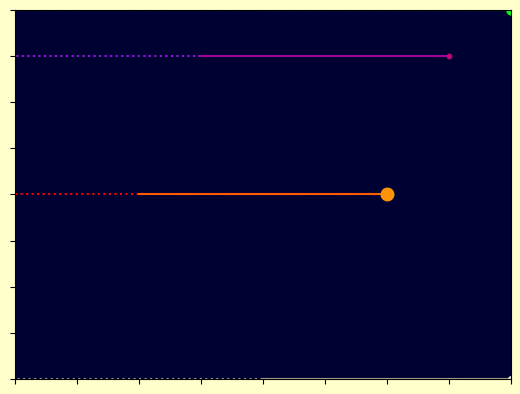

In [14]:
# for debugging
np.set_printoptions(formatter={'float': '{: .3e}'.format})

# sets up the plot
fig = plt.figure()
if is3D:
	ax = fig.add_subplot(111, projection='3d')
else:
	ax = fig.add_subplot()

if cart:
	ax.set_box_aspect(1)

fig.patch.set_facecolor('xkcd:ecru')
ax.patch.set_facecolor("xkcd:very dark blue")

# the path is the whole history of the object's motion
# the trail represents only the last few timesteps of the motion, like a blur
# test data to check colors
# û_vect = ax.quiver(1., 1., 0., -0.75, -0.75, 0.00025, color='xkcd:goldenrod', headwidth=0.00025)

test_data = [([1, -1], [1, 1], [0, 0]), ([1, 0], [1, 1], [0, 0]), ([1], [1], [0]),
			 ([0.5, -1.5], [0, 0], [0, 0]), ([0.5, -0.5], [0, 0], [0, 0]), ([0.5], [0], [0]),
			 ([1, -1], [-1, -1], [0, 0]), ([1, 0], [-1,-1], [0, 0]), ([1], [-1], [0]),
			 ([0.75, -1.25], [0.75, 0.75], [0, 0]), ([0.75, -0.25], [0.75, 0.75], [0, 0]), ([0.75], [0.75], [0])]

e_path, = plt.plot(*test_data[0][:ND], ":", color="xkcd:cerulean blue", label="_")
e_trail, = plt.plot(*test_data[1][:ND], "-", color="xkcd:aqua marine", label="_")
earth, = plt.plot(*test_data[2][:ND], "o", color="xkcd:bright green", label="Earth", markersize=6.5)

s_path, = plt.plot(*test_data[3][:ND], ":", color="xkcd:fire engine red", label="_")
s_trail, = plt.plot(*test_data[4][:ND], "-", color="xkcd:bright orange", label="_")
sun, = plt.plot(*test_data[5][:ND], "o", color="xkcd:tangerine", label="Sun", markersize=9)

m_path, = plt.plot(*test_data[6][:ND], ":", color="xkcd:cement", label="_")
m_trail, = plt.plot(*test_data[7][:ND], "-", color="xkcd:stone", label="_")
moon, = plt.plot(*test_data[8][:ND], "o", color="xkcd:light grey", label="Moon", markersize=4.2)

b_path, = plt.plot(*test_data[9][:ND], ":", color="xkcd:violet", label="_")
b_trail, = plt.plot(*test_data[10][:ND], "-", color="xkcd:barney purple", label="_")
barycenter, = plt.plot(*test_data[11][:ND], "o", color="xkcd:magenta", label="Barycenter", markersize=3.2)

# a list of all the plots associated with each body for easier plotting later
objs = [
	{
		'id': 'e',
		'path': e_path,
		'trail': e_trail,
		'obj': earth},
	{
		'id': 's',
		'path': s_path,
		'trail': s_trail,
		'obj': sun},
	{
		'id': 'm',
		'path': m_path,
		'trail': m_trail,
		'obj': moon},
	{
		'id': 'b',
		'path': b_path,
		'trail': b_trail,
		'obj': barycenter}]


ax.set_xlim(-DLIMS[0], DLIMS[0])
ax.set_ylim(-DLIMS[1], DLIMS[1])

if cart:
	ax.set_xlabel(f"{DIMS[0]} / AU")
	ax.set_ylabel(f"{DIMS[1]} / AU")

	plt.legend()

else:
	ax.set_xticklabels([])
	ax.set_yticklabels([])

if is3D:
	ax.set_zlim(-DLIMS[2], DLIMS[2])
	ax.set_zlabel(f"{DIMS[2]} / AU")


# sets up the gif
md = dict(title="3-Body Problem", artist="Rahul Maru")
writer = PillowWriter(fps=FPS, metadata=md)


<h1>Algorithm<h1>

## The Leap-Frog Method
The leap-frog integration method involves shifting the velocity calculations by half a time-step (midpoint summation) to improve accuracy. It goes as follows:
$$ \vec{a}_i = \frac{\vec{F}_i}{m} $$
$$ \vec{v}_{i + \frac{1}{2}} = \vec{v}_{i - \frac{1}{2}} + \vec{a}_i \Delta t $$
$$ \vec{s}_{i + 1} = \vec{s}_i + \vec{v}_{i + \frac{1}{2}} \Delta t$$

To set it up for the first timestep:
$$ \vec{v}_{\frac{1}{2}} = \vec{u} + \vec{a}_0 \frac{\Delta t}{2} $$
$$ \vec{s}_{1} = \vec{s}_0 + \vec{v}_{\frac{1}{2}} \Delta t$$



In [15]:
# leapfrog setup
F_es = Fg(me, ms, s0s-s0e)
F_ms = Fg(mm, ms, s0s-s0m)
F_me = Fg(mm, me, s0e-s0m)

# update the velocities by half a timestep
e['v'].append(ue + (F_es-F_me)/(2*me))
s['v'].append(us - (F_es+F_ms)/(2*ms))
m['v'].append(um + (F_ms+F_me)/(2*mm))

# update the positions by a full timestep using the velocity we just calculated
e['s'].append(s0e + e['v'][-1])
s['s'].append(s0s + s['v'][-1])
m['s'].append(s0m + m['v'][-1])

b['s'].append(calc_barycenter([(me, e['s'][-1]), (ms, s['s'][-1]), (mm, m['s'][-1])]))


<h2>The Simulation</h2>

Run the simulation and store the data.

In [16]:
x_proj_list = []
y_proj_list = []
visible = []

for t in T:
	# positions of each body at the last timestep
	se = e['s'][-1]
	ss = s['s'][-1]
	sm = m['s'][-1]

	# distances between bodies:
	#   r_xy is the vector pointing from x to y
	r_es = ss - se
	r_ms = ss - sm
	r_me = se - sm

	# forces between bodies
	#   f_xy is the force on x due to (and towards) y
	F_es = Fg(me, ms, r_es)
	F_ms = Fg(mm, ms, r_ms)
	F_me = Fg(mm, me, r_me)

	# update velocities
	e['v'].append(e['v'][-1] + (F_es-F_me)/me)
	s['v'].append(s['v'][-1] - (F_es+F_ms)/ms)
	m['v'].append(m['v'][-1] + (F_ms+F_me)/mm)

	# update positions
	e['s'].append(se + e['v'][-1])
	s['s'].append(ss + s['v'][-1])
	m['s'].append(sm + m['v'][-1])

	b['s'].append(calc_barycenter([(me, e['s'][-1]), (ms, s['s'][-1]), (mm, m['s'][-1])]))

	# unit vector pointing radially outward along the sun-earth axis
	û = r_se/norm(r_se)
	# unit vector of the Earth's velocity, which should be approximately perpendicular to û
	v = e['v'][-2]/norm(e['v'][-2])
	# unit vector orthogonal to the ecliptic, true South.
	w = np.cross(v, û)

	# vector and unit vector from the far side of earth to the moon
	r_em = -r_me - RE*û
	m_unit = r_em/norm(r_em)
	r_se = -r_es

	# projection parameters; the moon's position along the "u-axis"
	u_m = np.dot(r_em, û)*û
	# the mooon's position along the "w-axis"
	w_m = np.dot(r_em, w)*w
	
	# the unit vector of the moon's position on the horizontal (v-w) plane
	m_vw = (r_em - u_m)/norm(r_em - u_m)
	# the unit vector of the moon's position on the ecliptic (u-v) plane
	m_uv = (r_em - w_m)/norm(r_em - w_m)

	# "azimuth" and "polar" angles, in radians
	θ = np.arccos(np.dot(w, m_unit))
	φ = np.arccos(np.dot(m_uv, v))

	x_proj_list.append(np.sin(θ)*np.cos(φ))
	y_proj_list.append(np.cos(θ))
	visible.append(np.dot(m_uv, û)>=0)
	print(f"{'' if visible[-1] else 'in'}visible")


visible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
invisible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
visible
vi

Generate the GIF.

In [17]:
# extract the x, y, z data as separate lists and store them in objs
ex, ey, ez = [[p[i] for p in e['s']] for i in range(3)]
objs[0]['s'] = {'x': ex, 'y': ey, 'z': ez}
sx, sy, sz = [[p[i] for p in s['s']] for i in range(3)]
objs[1]['s'] = {'x': sx, 'y': sy, 'z': sz}
mx, my, mz = [[p[i] for p in m['s']] for i in range(3)]
objs[2]['s'] = {'x': mx, 'y': my, 'z': mz}
bx, by, bz = [[p[i] for p in b['s']] for i in range(3)]
objs[3]['s'] = {'x': bx, 'y': by, 'z': bz}

with writer.saving(fig, GIF_PATH, RES):
	if not cart:
		sun.set_data([2], [2])
		s_trail.set_data([2], [2])
		s_path.set_data([2], [2])
		barycenter.set_data([2], [2])
		b_path.set_data([2], [2])
		b_trail.set_data([2], [2])
	for t in T:
		# how far back the trail should go
		tr_lim = max(0, t-12)

		if cart:
			for o in objs:
				# plot the object at the edge of the screen if it goes out of bounds
				edge = lambda lim, s : min(lim*0.99, max(-lim*0.99, s[t]))

				if is3D:
					# centers the coordinates at CENT
					x, y, z = ([o['s'][dim][i] - objs[CENT]['s'][dim][i] for i in T] 
					for dim in DIMS)

				else:
					x, y = ([o['s'][dim][i] - objs[CENT]['s'][dim][i] for i in T] for dim in DIMS)

				# plot the path and the trail
				o['path'].set_data(x[:t], y[:t])
				o['trail'].set_data(x[tr_lim:t], y[tr_lim:t])
				o['obj'].set_data([edge(DLIMS[0], x)], [edge(DLIMS[1], y)])

				if is3D:
					o['path'].set_3d_properties(z[:t])
					o['trail'].set_3d_properties(z[tr_lim:t])
					o['obj'].set_3d_properties([edge(ZLIM, z)])
		else:
			# ax.text(0.75, 0.9, f"{t*86400/(T_SCALE*FPS)} days", fontdict = {'color': 'xkcd:goldenrod', 'size':'8'})
			if visible[t]:
				moon.set_data([x_proj_list[t]], [y_proj_list[t]])

		writer.grab_frame()


### Conservation
In this (and any) physical system, the sums of the linear momentum, angular momentum, and energy must be constant across all values of $t$.
They are calculated by the formulas:
$$\vec{p} = m \vec{v}$$
$$L = \vec{s} \times \vec{p}$$
$$U = KE + GPE$$

Plots the energy, momenta to see if they are indeed conserved.

In [18]:
# TODO reimplement this
raise NotImplementedError

# distances between bodies
# positions of each body at the last timestep
se = e['s']
ss = s['s']
sm = m['s']

# distances between bodies
r_es = ss - se
r_ms = ss - sm
r_me = se - sm


ΣGPE = GPE(me, ms, r_es) + GPE(mm, ms, r_ms) + GPE(mm, me, r_me)
ΣKE = KE(me, ve) + KE(ms, vs) + KE(mm, vm)
U = ΣGPE + ΣKE
Ulist.append(U)

pe = me*ve 
ps = ms*vs
pm = mm*vm
plist.append(np.linalg.norm(pe+ps+pm))

L = np.cross(pe, se) + np.cross(ps, ss) + np.cross(pm, sm)
Llist.append(np.linalg.norm(L))


plt.axhline(0, 0, max(tlist), color = "grey", linestyle="dashed", label="_")

plt.plot(tlist, plist)
plt.plot(tlist, Llist)
plt.plot(tlist, Ulist)

plt.legend(["0", "p", "L", "U"])

plt.ylim(-2e23, 7e23)

plt.show()


NotImplementedError: 